In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.base.datetools import dates_from_str
import datetime
import pylab
import matplotlib.pyplot as plt

from IO import get_data

In [92]:
# Check whether one time series G-causes the other
#    model:
#           y_t = Sum_{j=1}^p A_{11, j} x_{t-j} + Sum_{j=1}^p A_{12, j} y_{t-j} + Error
#    inputs:
#           data: T x 3 numpy array, where T = number of time steps
#               column 1: time index
#               column 2: x_t, regressor time trend
#               column 3: y_t: dependent variable time trend
#    output:
#           logarithm of F-statistic from F-Test with null hypothesis A_{12}| = 0
def granger_causes(ndata, maxlag=2, ic=None, filelist=None, data_kept=None):
    if filelist == None:
        collist = [''] * (ndata.shape[1]-1)
    else:
        collist = map(lambda x: x.split('/')[-1][:-4].lower(), filelist)
        
    if data_kept != None:
        ndata = ndata[-data_kept:,:]
    data = pd.DataFrame(ndata[:,1:], columns=collist)
    
    date_col = [datetime.datetime.fromtimestamp(x) for x in ndata[:,[0]]]
    dates = pd.Series(date_col)
    data.index = dates
    model = VAR(data)
    results = model.fit(maxlag, ic=ic)
    results.test_causality(list(data)[-1], list(data)[0], kind='f')
    if len(filelist) > 2:
        data_without = pd.DataFrame(ndata[:,2:], columns=collist[1:])
        data_without.index = dates
        model_without = VAR(data_without)
        results_without = model_without.fit(maxlag, ic=ic)
        return model, results, ndata[:,-1], model.predict(results.params)[:,-1], model_without.predict(results_without.params)[:,-1]
    else:
        return model, results, ndata[:,-1], None, None

In [113]:
filelist = ["data/AAPL.csv", "data/ADI.csv"]
# filelist = ["data/AAPL.csv", "data/AMZN.csv", "data/GOOG.csv", "data/ADI.csv"]
# filelist = ["data/AAPL.csv", "data/MU.csv"]
filelist = ["data/AAPL.csv", "data/AMZN.csv", "data/GOOG.csv", "data/MU.csv"]
d = get_data(filelist)

Reading data/AAPL.csv
Reading data/AMZN.csv
Reading data/GOOG.csv
Reading data/MU.csv


In [115]:
model, results, predict_gt, predict_with, predict_without = granger_causes(d, filelist=filelist, maxlag=15, ic='bic', data_kept=2000)
# results.summary()

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         4.949649         3.842625            0.026  (1, 7976)
H_0: ['aapl'] do not Granger-cause mu
Conclusion: reject H_0 at 5.00% significance level


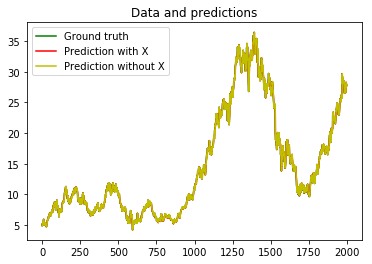

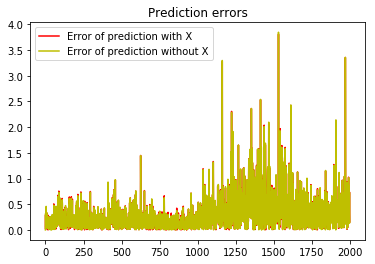

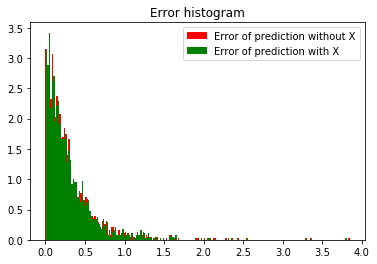

0.295242202555
0.294721626334


In [120]:
# This block only works when using filelist of length 4
plt.plot(predict_gt[predict_gt.size-predict_with.size:], 'g')
plt.plot(predict_with, 'r')
plt.plot(predict_without, 'y')
plt.legend(['Ground truth', 'Prediction with X', 'Prediction without X'])
plt.title('Data and predictions')
plt.show()

errors_with = abs(predict_with-predict_gt[predict_gt.size-predict_with.size:])
errors_without = abs(predict_without-predict_gt[predict_gt.size-predict_with.size:])
plt.plot(errors_with, 'r')
plt.plot(errors_without, 'y')
plt.legend(['Error of prediction with X', 'Error of prediction without X'])
plt.title('Prediction errors')
plt.show()

plt.title('Error histogram')
plt.hist(errors_without, 200, normed=1,facecolor='red')
plt.hist(errors_with, 200, normed=1,facecolor='green')
plt.legend(['Error of prediction without X', 'Error of prediction with X'])
plt.show()

print(errors_without.mean())
print(errors_with.mean())

In [117]:
def regression_data(data, order=2):
    ''' 
    Convert a column of data n into (n-order)*(order) and (n-order)*1 time series data for regression
    Note that time is not shown in this model.
    '''
    if len(data.shape) == 1:
        data = data.reshape(data.size,1)
    assert(data.shape[1] == 1)
    assert(data.shape[0] > order)
    assert(order >= 1)
    Y = data[order:,:]
    size = data.shape[0]
    data_t = data.transpose()
    
    # prepare X: for speed, we truncate, reshape and then interleave 
    X = np.zeros((size-order,order))
    for i in xrange(size-order):
        X[i] = data_t[0,i:i+order]
    
    return X, Y
        
def regression(data, order=2, data_kept=None):
    '''Do a joint regression on multiple time series'''
    Xs = list()
    Ys = list()
    if data_kept != None:
        data = data[-data_kept:,:]
    for i in xrange(data.shape[1]):
        X,Y = regression_data(data[:,i], order=order)
        Xs.append(X)
        Ys.append(Y)
    Xs = np.concatenate(Xs, axis=1)
    Ys = np.concatenate(Ys, axis=1)
    
    params = np.dot(np.dot(np.linalg.inv(np.dot(Xs.transpose(),Xs)), Xs.transpose()),Ys)
    predictions = np.dot(Xs, params)
    return params, predictions, Ys

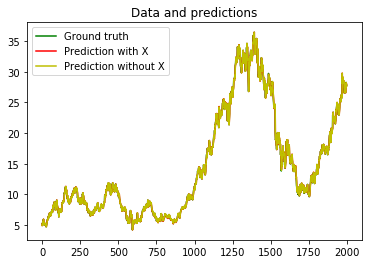

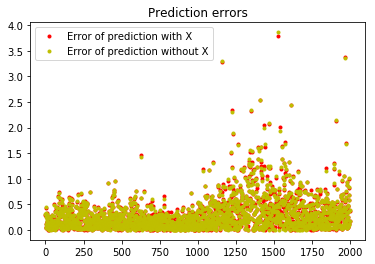

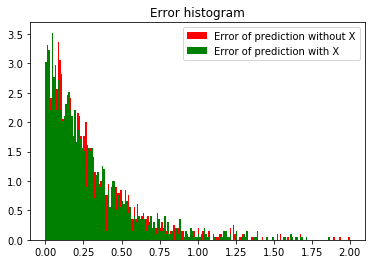

0.295007456111
0.293872671452


In [122]:
order = 15
error_range = [0,2]
data_kept = 2000

params_with, predictions_with, Ys = regression(d[:,1:], order=order, data_kept=data_ke)
params_without, predictions_without, Ys = regression(d[:,2:], order=order)
query_gt = Ys[:,-1]
query_with = predictions_with[:,-1]
query_without = predictions_without[:,-1]
plt.plot(query_gt, 'g')
plt.plot(query_with, 'r')
plt.plot(query_without, 'y')
plt.legend(['Ground truth', 'Prediction with X', 'Prediction without X'])
plt.title('Data and predictions')
plt.show()

errors_with = abs(query_with-query_gt)
errors_without = abs(query_without-query_gt)
plt.plot(errors_with, 'r')
plt.plot(errors_without, 'y')
plt.legend(['Error of prediction with X', 'Error of prediction without X'])
plt.title('Prediction errors')
plt.show()

plt.title('Error histogram')
plt.hist(errors_without, 200, normed=1,range=error_range, facecolor='red')
plt.hist(errors_with, 200, normed=1,range=error_range, facecolor='green')
plt.legend(['Error of prediction without X', 'Error of prediction with X'])
plt.show()

print(errors_without.mean())
print(errors_with.mean())